# Import the needed APIs

In [1]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
pd.set_option('display.max_rows', None, 'display.max_columns', None)
from sklearn.preprocessing import OneHotEncoder 
import math
import sys
np.set_printoptions(threshold=sys.maxsize)

# Data import

In [2]:
# Unaltered data
orig_data=pd.read_csv(r"") 
print("Original data shape is:",orig_data.shape)
print("Number of missing values is:",orig_data.isnull().sum().sum())
#print(orig_data.head(2))

Original data shape is: (4024, 16)
Number of missing values is: 0


# Initial processing

In [3]:
mod_data=orig_data.drop(["Tumor Size"],axis=1) # T1,2,3 is the categorical representation of tumor size
mod_data=mod_data.drop(["Reginol Node Positive","Regional Node Examined"],axis=1)  # The N-stage represents the categorical representation of positive nodes found. Not all of them are marked correctly 
mod_data=mod_data.drop(["differentiate"],axis=1)  # Differentitate is the same as grade (1:well-diff,2:moderate,3:poor)
print("Data shape after eliminating unnecessary columns is:",mod_data.shape)

Data shape after eliminating unnecessary columns is: (4024, 12)


### Categorizing "survival months" and "age"

In [4]:
to_categorize_survival=mod_data["Survival Months"]                            # categorizing the survival months variable

bin_width_s=6
num_bins_s=math.ceil(to_categorize_survival.max()/bin_width_s)+1

bins_s=[0]*num_bins_s
group_names_s=[0]*(num_bins_s-1)
group_names_s_str=[0]*(num_bins_s-1)
bins_s[0]=0
for i in range(1,num_bins_s):
    bins_s[i]=i*bin_width_s
    group_names_s[i-1]=i
    group_names_s_str[i-1]=str(i)
num_bins_s_output=num_bins_s
categorized_survival=pd.cut(to_categorize_survival,bins_s,labels=group_names_s)
##########################################################################
to_categorize_age=mod_data["Age"]                                            # categorizing the age variable

bin_width=10
num_bins=math.ceil(to_categorize_age.max()/bin_width)+1

bins=[0]*num_bins
group_names=[0]*(num_bins-1)
bins[0]=0
for i in range(1,num_bins):
    bins[i]=i*bin_width
    group_names[i-1]=i
categorized_age=pd.cut(to_categorize_age,bins,labels=group_names)
##########################################################################  # placing the categorized variables
mod_data.drop(["Age"],axis=1,inplace=True)
mod_data.drop(["Survival Months"],axis=1,inplace=True)
mod_data.insert(1,["Age"],categorized_age,True)
mod_data.insert(1,["Survival Months"],categorized_survival,True)
print("Data shape after categorizing age and survival months is:", mod_data.shape)
#print(mod_data.head(2))

Data shape after categorizing age and survival months is: (4024, 12)


### Integer encoding (replacing strings with numeric values) for all variables except for "age" and "survival months" because this is included in the previous step.

### Integer encoding is sufficient for ordinal data. Non-ordinal variables will be one hot encoded next. 

In [5]:
string_data=mod_data.drop(["Age","Survival Months"],axis=1)   # Convert the string categorical data to numeric values 

le=LabelEncoder()                  
for i in string_data.columns:
    string_data[i]=le.fit_transform(string_data[i])
    
string_data.insert(1,"Age",mod_data["Age"],True)
string_data.insert(1,"Survival Months",mod_data["Survival Months"],True)

processed_data=string_data
print("Data shape after replacing string values with numeric values is:", processed_data.shape)
#print(mod_data.head(2))

Data shape after replacing string values with numeric values is: (4024, 12)


### One-hot encoding for: "race", "marital status", "estrogen status", and "progesterone" status

In [6]:
############################################################ Race
white=[]
black=[]
other=[]

a=pd.DataFrame(processed_data["Race"])
converted = OneHotEncoder().fit_transform(a).toarray()
for i in range(0, len(a)):
    white.append(int(converted[i][2]))
    other.append(int(converted[i][1]))
    black.append(int(converted[i][0]))
white=pd.Series(white)
black=pd.Series(black)
other=pd.Series(other)
processed_data.drop(["Race"],axis=1,inplace=True)
processed_data.insert(1,"white",white,True)
processed_data.insert(1,"black",black,True)
processed_data.insert(1,"other",other,True)

#print(processed_data)
############################################################# Marital status
married=[]
single=[]
divorced=[]
widowed=[]
separated=[]

b=pd.DataFrame(processed_data["Marital Status"])
converted = OneHotEncoder().fit_transform(b).toarray()
for i in range(0, len(b)):
    married.append(int(converted[i][1]))
    single.append(int(converted[i][3]))
    divorced.append(int(converted[i][0]))
    widowed.append(int(converted[i][4]))
    separated.append(int(converted[i][2]))

married=pd.Series(married)
single=pd.Series(single)
divorced=pd.Series(divorced)
widowed=pd.Series(widowed)
separated=pd.Series(separated)

processed_data.drop(["Marital Status"],axis=1,inplace=True)
processed_data.insert(1,"married",married,True)
processed_data.insert(1,"single",single,True)
processed_data.insert(1,"divorced",divorced,True)
processed_data.insert(1,"widowed",widowed,True)
processed_data.insert(1,"separated",separated,True)
############################################################# Estrogen status
estrogen_positive=[]
estrogen_negative=[]

c=pd.DataFrame(processed_data["Estrogen Status"])
converted = OneHotEncoder().fit_transform(c).toarray()
for i in range(0, len(c)):
    estrogen_positive.append(int(converted[i][1]))
    estrogen_negative.append(int(converted[i][0]))

estrogen_positive=pd.Series(estrogen_positive)
estrogen_negative=pd.Series(estrogen_negative)

processed_data.drop(["Estrogen Status"],axis=1,inplace=True)
processed_data.insert(1,"estrogen_positive",estrogen_positive,True)
processed_data.insert(1,"estrogen_negative",estrogen_negative,True)
############################################################# Progesterone status
progesterone_positive=[]
progesterone_negative=[]

d=pd.DataFrame(processed_data["Progesterone Status"])
converted = OneHotEncoder().fit_transform(d).toarray()
for i in range(0, len(d)):
    progesterone_positive.append(int(converted[i][1]))
    progesterone_negative.append(int(converted[i][0]))

progesterone_positive=pd.Series(progesterone_positive)
progesterone_negative=pd.Series(progesterone_negative)

processed_data.drop(["Progesterone Status"],axis=1,inplace=True)
processed_data.insert(1,"progesterone_positive",progesterone_positive,True)
processed_data.insert(1,"progesterone_negative",progesterone_negative,True)
print("Data shape after one-hot encoding race, marital status, estrogen, and progesterone level:",processed_data.shape)
#print(processed_data.head(7))

Data shape after one-hot encoding race, marital status, estrogen, and progesterone level: (4024, 20)


# Classification- Decision Tree

### Choosing inputs and outputs

In [7]:
to_investigate=processed_data[["Survival Months"]] # elements to predict

inputs= processed_data.drop(["Survival Months"],axis=1)
#inputs= processed_data[["T Stage "]] # The elemnts to train the model
#inputs.insert(0,"T Stage ",processed_data[["T Stage "]],True) # The elemnts to train the model
#inputs.insert(0,"N Stage ",processed_data[["N Stage"]],True) # The elemnts to train the model

### Class balancing to give equal weights for "survival age" groups

In [8]:
for i in range (1,num_bins_s_output):
    print("Number of points for bin %s before balancing is:" %i,len(inputs[to_investigate["Survival Months"]==i].index))

ros=RandomOverSampler(random_state=0)
inputs_resampled, to_investigate_resampled=ros.fit_resample(inputs, to_investigate)
for i in range (1,num_bins_s_output):
    print("Number of points for bin %s after balancing is:" %i,len(inputs_resampled[to_investigate_resampled["Survival Months"]==i].index))

Number of points for bin 1 before balancing is: 32
Number of points for bin 2 before balancing is: 39
Number of points for bin 3 before balancing is: 53
Number of points for bin 4 before balancing is: 61
Number of points for bin 5 before balancing is: 55
Number of points for bin 6 before balancing is: 62
Number of points for bin 7 before balancing is: 89
Number of points for bin 8 before balancing is: 136
Number of points for bin 9 before balancing is: 365
Number of points for bin 10 before balancing is: 374
Number of points for bin 11 before balancing is: 373
Number of points for bin 12 before balancing is: 352
Number of points for bin 13 before balancing is: 355
Number of points for bin 14 before balancing is: 376
Number of points for bin 15 before balancing is: 334
Number of points for bin 16 before balancing is: 340
Number of points for bin 17 before balancing is: 377
Number of points for bin 18 before balancing is: 251
Number of points for bin 1 after balancing is: 377
Number of p

### Building the biggest possible tree to determine the alpha value for pruning

### Note: Pruning will be done by finding the alpha value by CV, but the actual output will be obtained using typical 75/25 split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(inputs_resampled, to_investigate_resampled, test_size=0.25, random_state=42) #Splitting into training and testing

##################################################### Build the biggest possible tree to perform pruning later
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
score_training=clf.score(X_train, y_train)
score_testing=clf.score(X_test, y_test)
print("Training accuracy before pruning using 75/25:",score_training)
print("Testing accuracy before pruning using 75/25:",score_testing)

clf_cv =  DecisionTreeClassifier(random_state=42)   
k_folds = KFold(n_splits = 5)
score_cv= cross_val_score(clf_cv, inputs_resampled, to_investigate_resampled, cv = k_folds)
print("Accuracy using CV before pruning",score_cv.mean())

Training accuracy before pruning using 75/25: 0.577323639221851
Testing accuracy before pruning using 75/25: 0.39952857984678847
Accuracy using CV before pruning 0.35472751879470765


### Plot the accuracy curve to find alpha

<Figure size 1008x504 with 0 Axes>

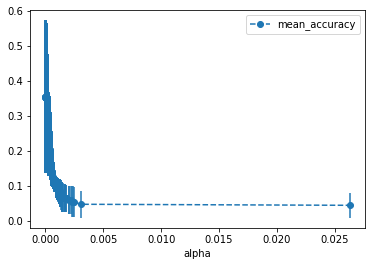

In [10]:
path=clf_cv.cost_complexity_pruning_path(inputs_resampled, to_investigate_resampled)
alphas=path['ccp_alphas']
alpha_loop_values=[]
for i in alphas:
    tree=DecisionTreeClassifier(random_state=42,ccp_alpha=i)
    k_folds = KFold(n_splits = 5)
    score_cv= cross_val_score(tree, inputs_resampled, to_investigate_resampled, cv = k_folds)
    alpha_loop_values.append([i, np.mean(score_cv), np.std(score_cv)])
plt.figure(figsize=(14,7))
alpha_results=pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])
#print(alpha_loop_values)
alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')
plt.show()

### Choose alpha from plot that maintains good accuracy and reduces overfitting

In [13]:
##################### Choose alpha from plot
chosen_alpha=0    # 0 indicates no pruning
tree=DecisionTreeClassifier(ccp_alpha=chosen_alpha,random_state=12)
tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
print("Training accuracy using 75/25 after pruning is:",accuracy_score(y_train,y_train_pred))
print("Testing accuracy using 75/25 after pruning is:",accuracy_score(y_test,y_test_pred))

Training accuracy using 75/25 after pruning is: 0.577323639221851
Testing accuracy using 75/25 after pruning is: 0.4001178550383029


### Plotting the confusion matrix and the decision tree

C:\Users\mnaser1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

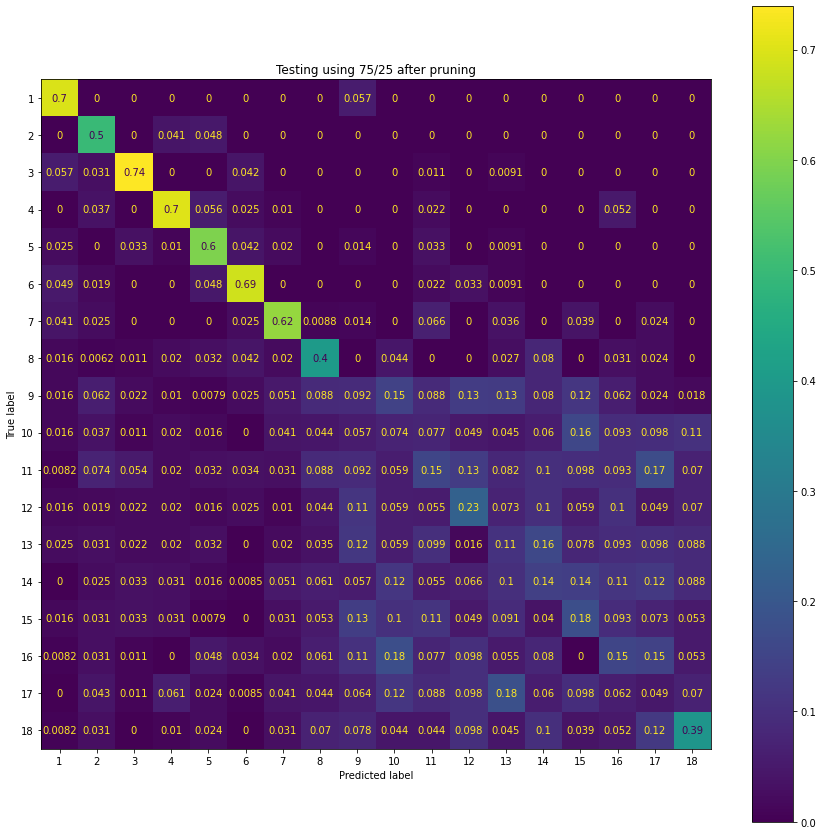

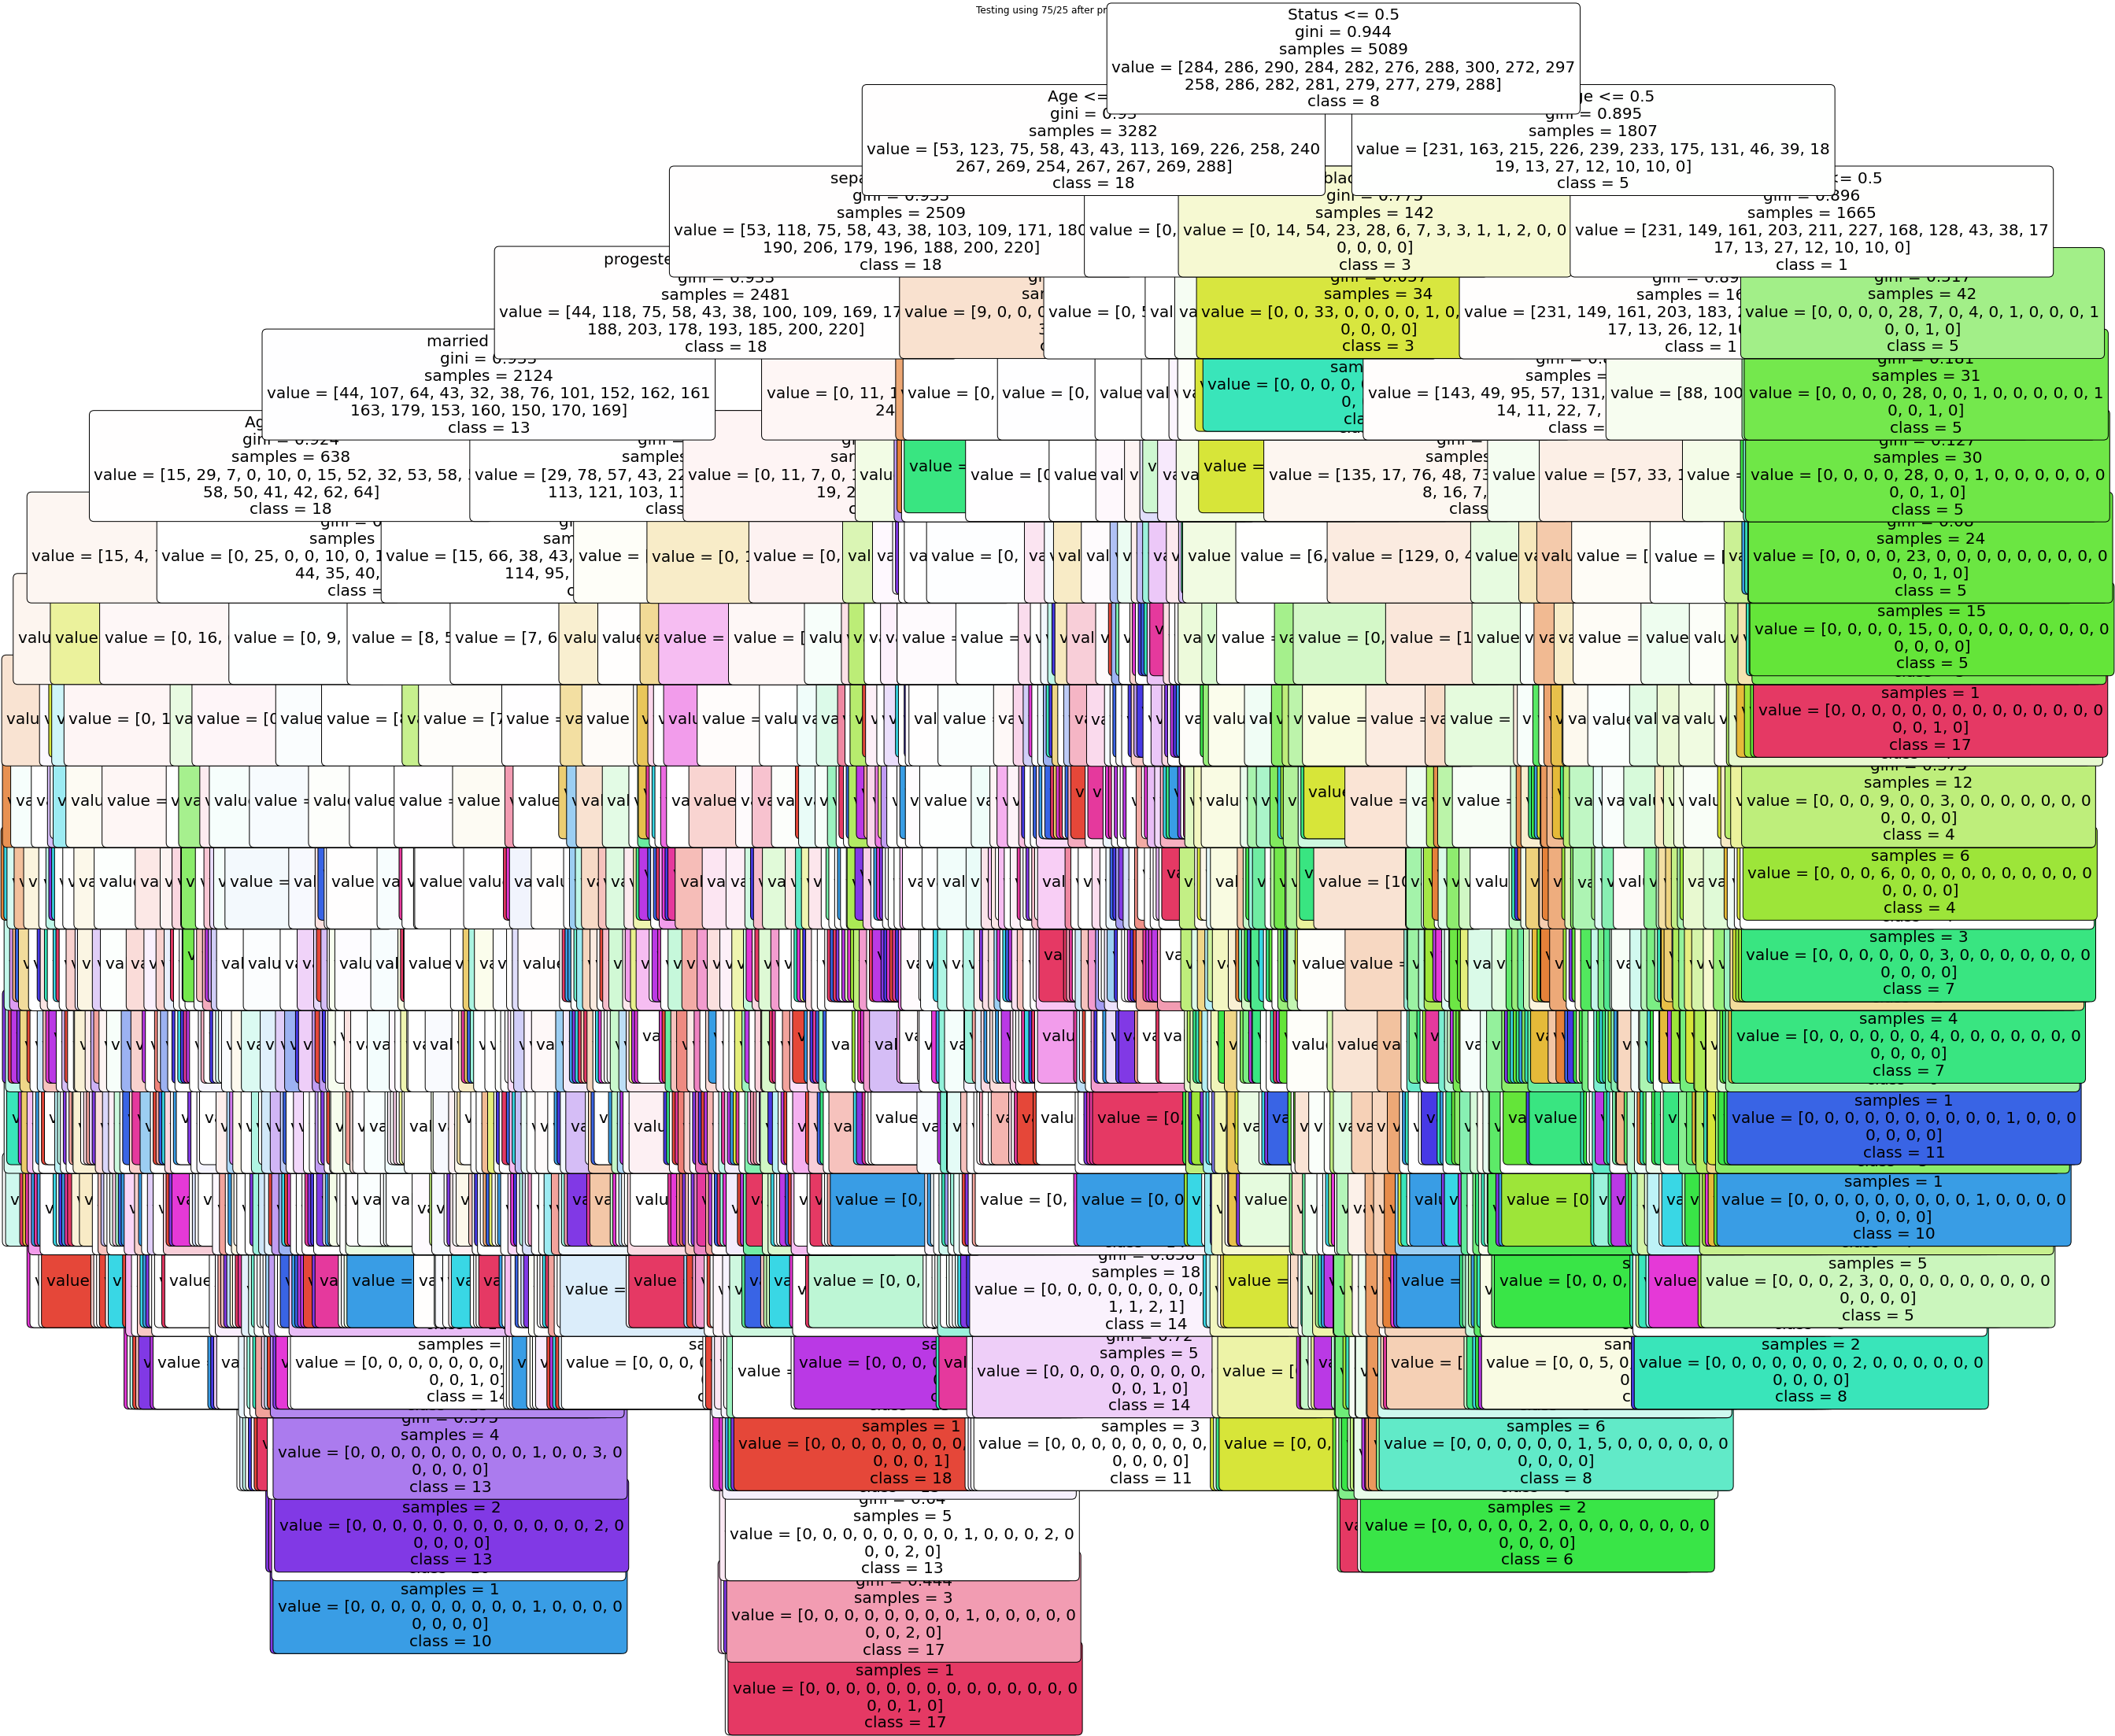

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(tree, X_test, y_test, display_labels=group_names_s_str,normalize="pred",ax=ax)
plt.title("Testing using 75/25 after pruning")
plt.grid(False)
plt.show

plt.figure(figsize=(40,40))
plot_tree(tree, filled=True, rounded=True, class_names=group_names_s_str, feature_names=inputs_resampled.columns,fontsize=20)
plt.title("Testing using 75/25 after pruning")
plt.show